<a href="https://colab.research.google.com/github/lucia1970-student/Autism_Repo/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import google.colab.drive
google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks/cours_python/FSCI2610/projet

/content/drive/MyDrive/Colab Notebooks/cours_python/FSCI2610/projet


In [ ]:
import pandas as pd

df=pd.read_csv('voice_data.csv')
df.head()
df.loc[df.Group != "TD"].count()

,0
Group,84
avg_f0,84
avg_F1,84
avg_F2,84
avg_F3,84
avg_F4,84
mean_hnr,84
jitter,84
shimmer,84
dispersion_formantique,84


In [ ]:
ctrl_data = df.loc[df.Group != 'TD']
y = ctrl_data["Group"].copy() # Create a copy
ctrl_data.loc[ctrl_data.Group =="IC", "Group"] = "CTRL" # Modify the 'Group' column within ctrl_data
ctrl_data.loc[ctrl_data.Group == "SLI", "Group"] = "CTRL" # Modify the 'Group' column within ctrl_data
y =ctrl_data.Group
#X = ctrl_data.drop("Group", axis=1)
X = ctrl_data.loc[:,['avg_F1', 'mean_hnr', 'jitter_s', 'shimmer']]
X, y

(     avg_F1  mean_hnr  jitter_s   shimmer
 0    778.00     10.75  1.205160  1.377360
 1    662.70     12.25  0.560049  1.389308
 2    884.55     12.90  0.722608  1.185426
 3    652.05      8.65  0.045519  1.645441
 4    739.75      8.30  1.151768  1.544171
 ..      ...       ...       ...       ...
 79  1048.20      8.65  0.689445  1.353881
 80   782.05     11.00  0.444379  0.952392
 81   771.40     10.35  2.336884  1.138822
 82   682.65     12.10  0.655235  1.052067
 83  1020.15      8.90  2.139388  1.266389
 
 [84 rows x 4 columns],
 0      ASD
 1      ASD
 2      ASD
 3      ASD
 4      ASD
       ... 
 79    CTRL
 80    CTRL
 81    CTRL
 82    CTRL
 83    CTRL
 Name: Group, Length: 84, dtype: object)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
print("Explained variance ratio:",(sum(pca.explained_variance_ratio_)))

X_Scaled = StandardScaler().fit_transform(X_pca)
y_numeric = LabelEncoder().fit_transform(y)

len(X_Scaled), len(y_numeric)

Explained variance ratio: 1.0


(84, 84)

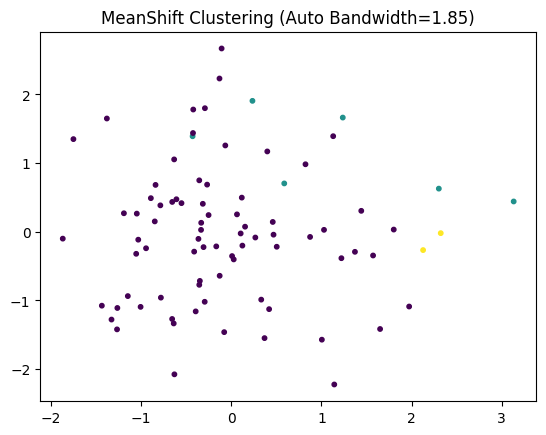

In [ ]:
#Trying MeanShift clustering.

import matplotlib.pyplot as plt

from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift

# Estimate bandwidth automatically
bw_auto = estimate_bandwidth(X_Scaled, quantile=0.2)

# Apply MeanShift with auto-estimated bandwidth
meanshift = MeanShift(bandwidth=bw_auto)
clusters = meanshift.fit_predict(X_Scaled)

# Plot results
plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=clusters, cmap="viridis", s=10)
plt.title(f"MeanShift Clustering (Auto Bandwidth={bw_auto:.2f})")
plt.show()


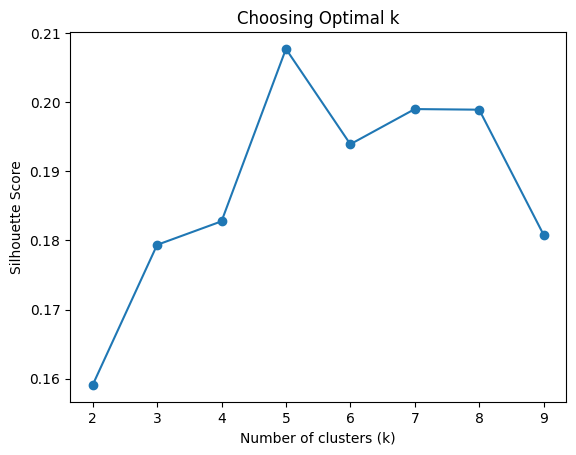

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different values of k
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_Scaled)
    score = silhouette_score(X_Scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choosing Optimal k")
plt.show()

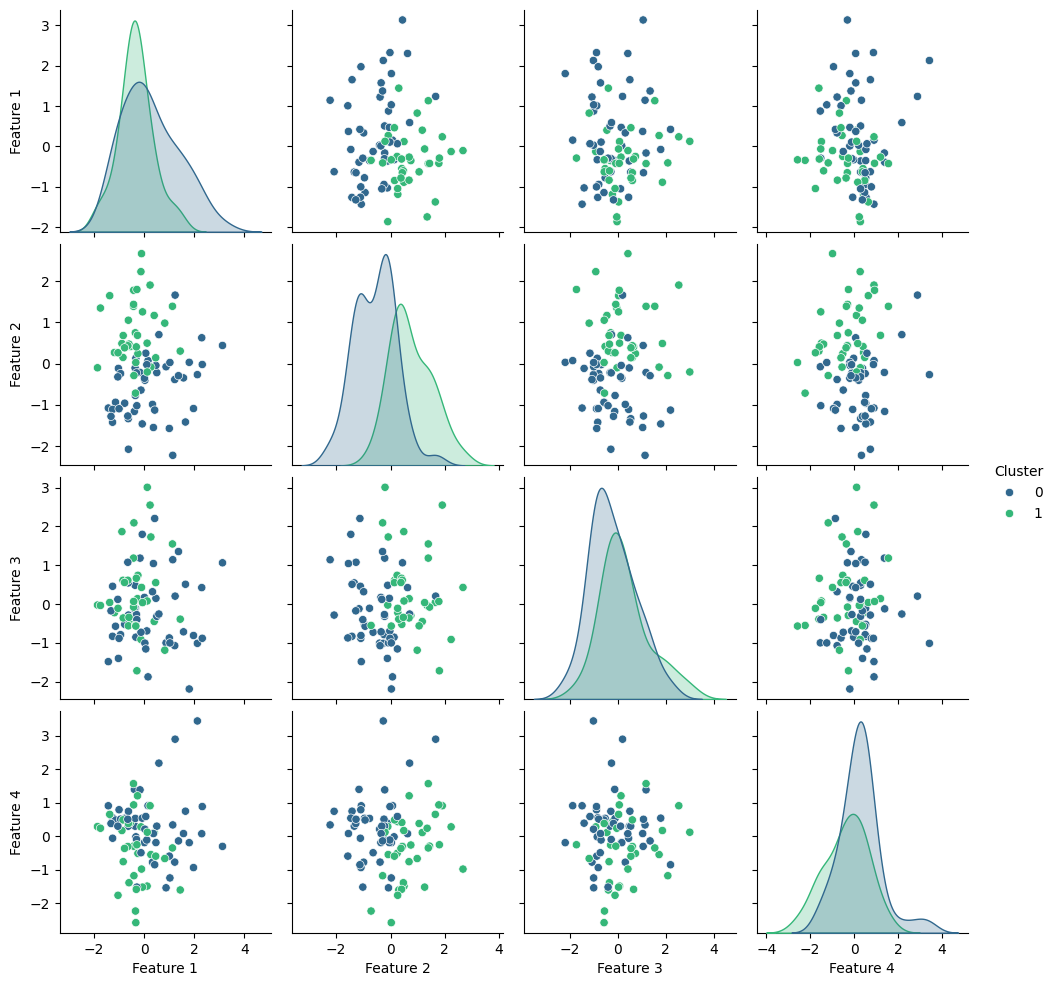

In [ ]:
import seaborn as sns
import pandas as pd

df1 = pd.DataFrame(X_Scaled, columns=["Feature 1", "Feature 2", "Feature 3", "Feature 4"])
df1["Cluster"] = KMeans(n_clusters=2, random_state=42).fit_predict(X_Scaled)

sns.pairplot(df1, hue="Cluster", palette="viridis")
plt.show()

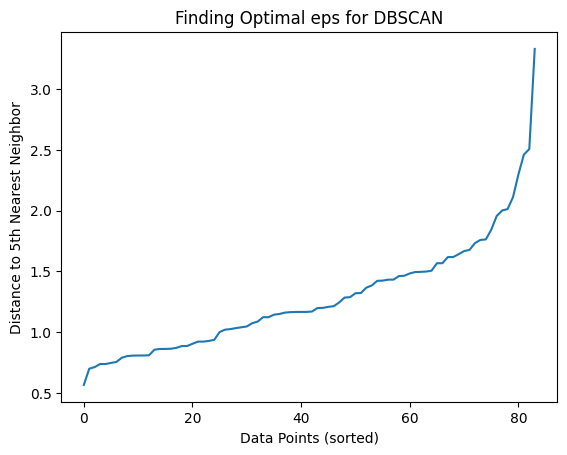

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X_Scaled)
distances, indices = neighbors.kneighbors(X_Scaled)

# Sort distances for elbow method
sorted_distances = np.sort(distances[:, 4])  # 4 because index starts at 0
plt.plot(sorted_distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.title("Finding Optimal eps for DBSCAN")
plt.show()

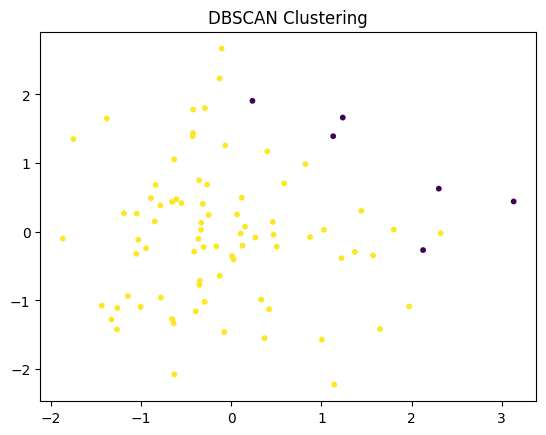

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.55, min_samples=5)  # Adjust min_samples if needed
labels = dbscan.fit_predict(X_Scaled)

plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=labels, cmap="viridis", s=10)
plt.title("DBSCAN Clustering")
plt.show()

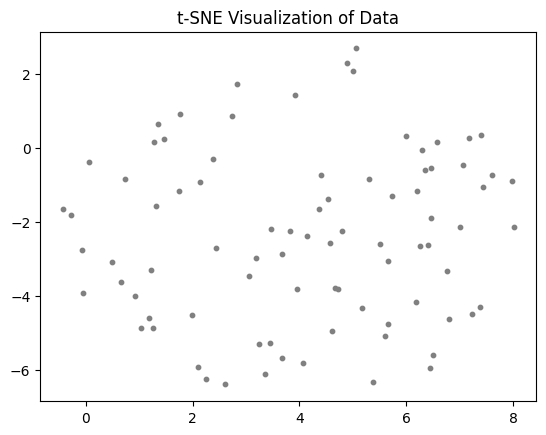

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_Scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color="gray")
plt.title("t-SNE Visualization of Data")
plt.show()

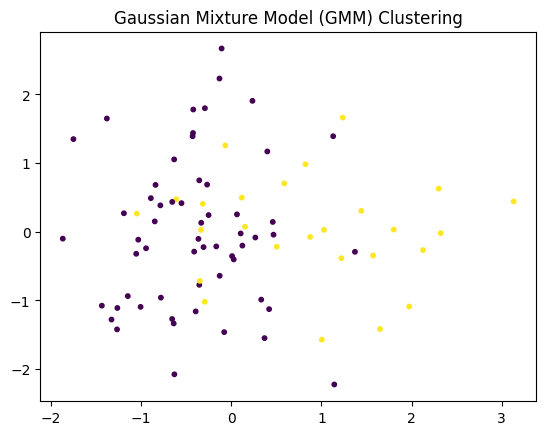

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm_labels = gmm.fit_predict(X_Scaled)

plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=gmm_labels, cmap="viridis", s=10)
plt.title("Gaussian Mixture Model (GMM) Clustering")
plt.show()


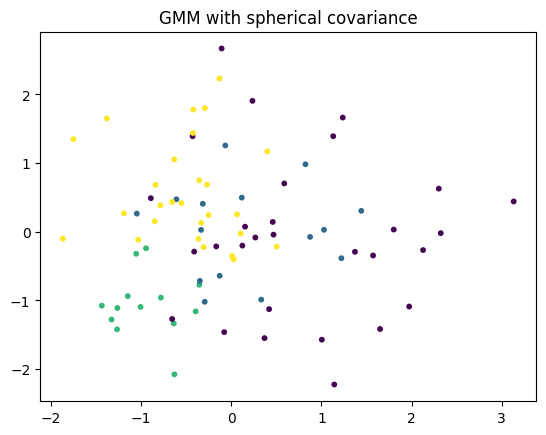

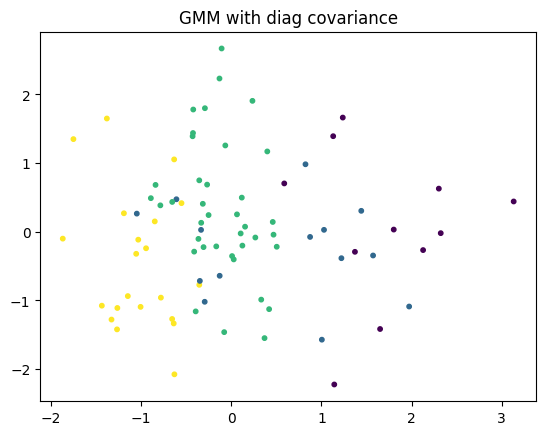

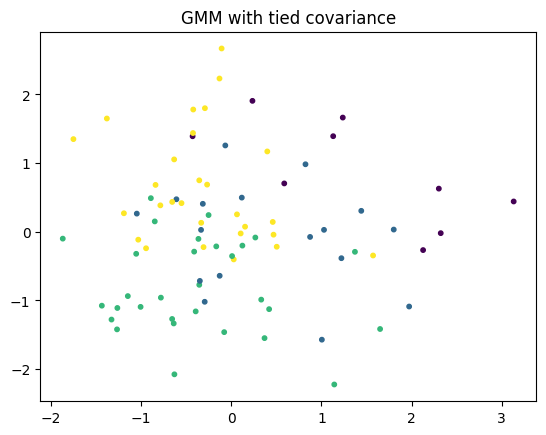

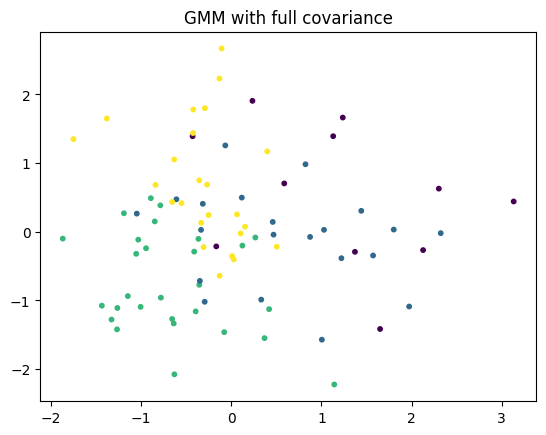

In [ ]:
for cov_type in ["spherical", "diag", "tied", "full"]:
    gmm = GaussianMixture(n_components=4, covariance_type=cov_type, random_state=42)
    labels = gmm.fit_predict(X_Scaled)

    plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=labels, cmap="viridis", s=10)
    plt.title(f"GMM with {cov_type} covariance")
    plt.show()


Type de covariance: spherical, AIC: 3543.3683227608963, BIC: 3570.1073075481727
Type de covariance: diag, AIC: 1606.0033047722209, BIC: 1647.3271903525572
Type de covariance: tied, AIC: 1559.8615730115964, BIC: 1606.0470921896194
Type de covariance: full, AIC: 1557.2293260417741, BIC: 1627.7230132082302

Meilleur type de covariance en se basant sur AIC: 'full'

Meilleur type de covariance en se basant sur BIC: 'tied'


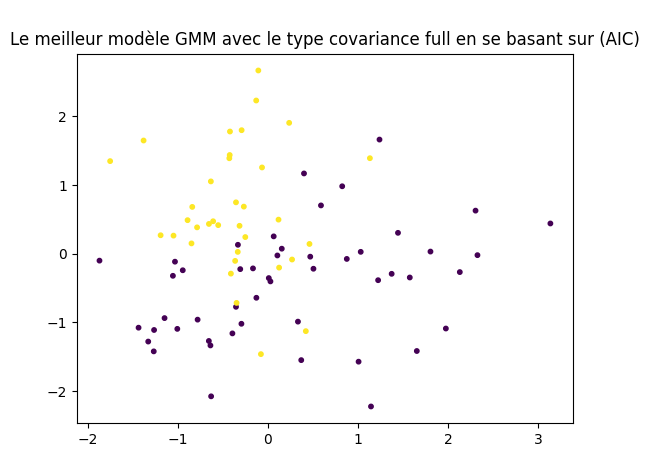

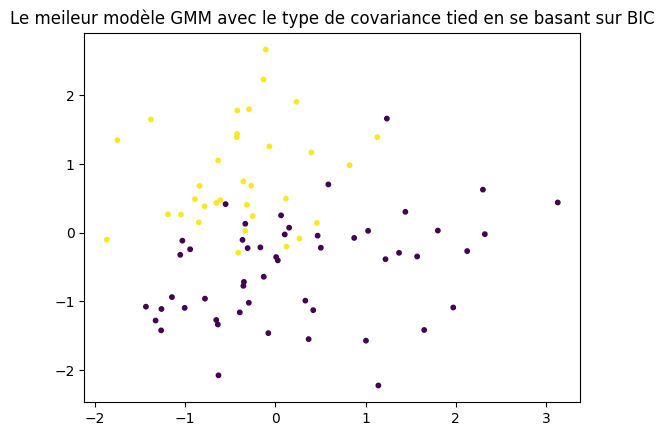

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

#X est normalisé avec StandardScaler plus haut.

best_gmm = None
best_aic = float('inf')
best_bic = float('inf')
best_cov_type_aic = ""
best_cov_type_bic = ""

covariance_types = ["spherical", "diag", "tied", "full"]

for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=2, covariance_type=cov_type, random_state=42)
    gmm.fit(X)

    aic = gmm.aic(X)
    bic = gmm.bic(X)

    print(f"Type de covariance: {cov_type}, AIC: {aic}, BIC: {bic}")

    if aic < best_aic:
        best_aic = aic
        best_cov_type_aic = cov_type

    if bic < best_bic:
        best_bic = bic
        best_cov_type_bic = cov_type

print(f"\nMeilleur type de covariance en se basant sur AIC: '{best_cov_type_aic}'")
print(f"\nMeilleur type de covariance en se basant sur BIC: '{best_cov_type_bic}'")

# Visualiser les meilleures modèles baser sur AIC et BIC, respectivement.
best_gmm_aic = GaussianMixture(n_components=2, covariance_type=best_cov_type_aic, random_state=42)
labels_aic = best_gmm_aic.fit_predict(X_Scaled)

best_gmm_bic = GaussianMixture(n_components=2, covariance_type=best_cov_type_bic, random_state=42)
labels_bic = best_gmm_bic.fit_predict(X_Scaled)

plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=labels_aic, cmap="viridis", s=10)
plt.title(f"\nLe meilleur modèle GMM avec le type covariance {best_cov_type_aic} en se basant sur (AIC)")
plt.show()

plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=labels_bic, cmap="viridis", s=10)
plt.title(f"Le meileur modèle GMM avec le type de covariance {best_cov_type_bic} en se basant sur BIC")
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


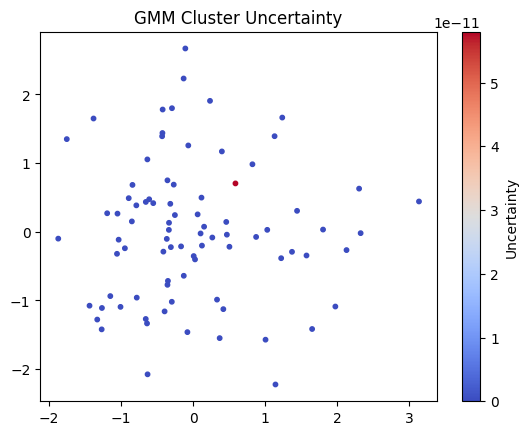

In [ ]:
import numpy as np

gmm_probs = gmm.predict_proba(X_Scaled)  # Probabilities for each cluster
uncertainty = 1 - np.max(gmm_probs, axis=1)  # Higher means less confidence

plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=uncertainty, cmap="coolwarm", s=10)
plt.colorbar(label="Uncertainty")
plt.title("GMM Cluster Uncertainty")
plt.show()


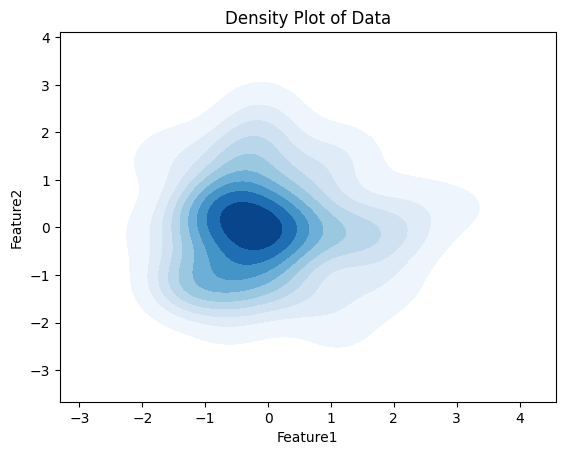

In [ ]:
import seaborn as sns
import pandas as pd

# Create a DataFrame from your data
df_kde = pd.DataFrame(X_Scaled, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4'])

# Create a density plot using seaborn.kdeplot
sns.kdeplot(data=df_kde, x='Feature1', y='Feature2', cmap="Blues", fill=True)
plt.title("Density Plot of Data")
plt.show()

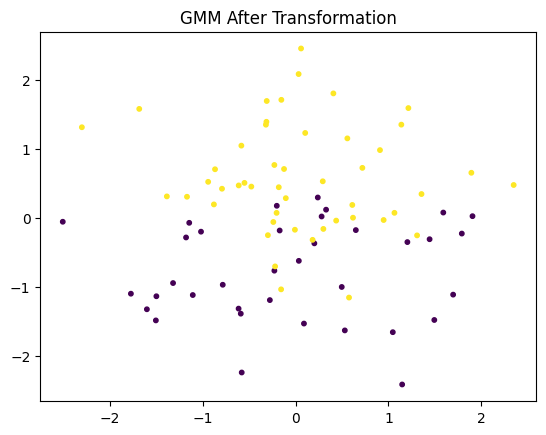

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")
X_transformed = pt.fit_transform(X_Scaled)

gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X_transformed)

plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels, cmap="viridis", s=10)
plt.title("GMM After Transformation")
plt.show()


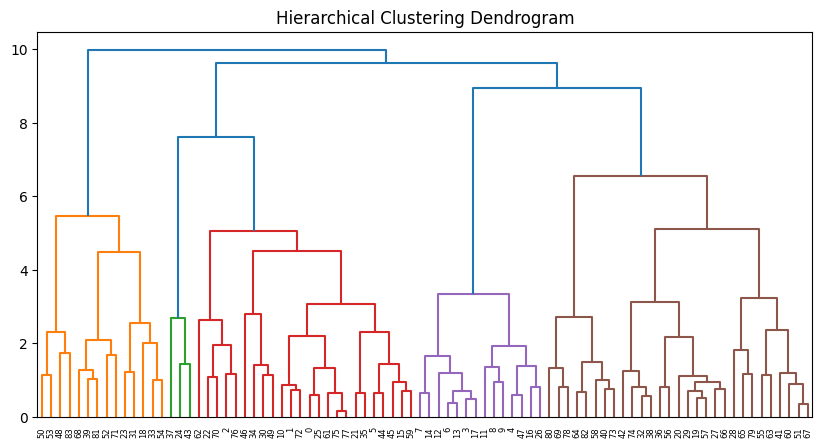

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_Scaled, method="ward")  # Ward method helps with compact clusters
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


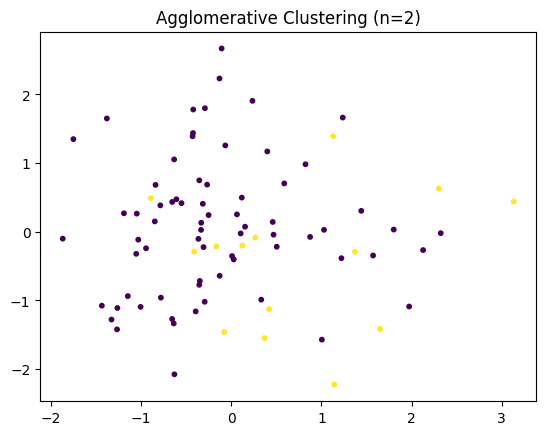

Silhouette Score for Hierarchical Clustering: 0.217


In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels = agg_clustering.fit_predict(X_Scaled)

plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=labels, cmap="viridis", s=10)
plt.title("Agglomerative Clustering (n=2)")
plt.show()

from sklearn.metrics import silhouette_score

score = silhouette_score(X_Scaled, labels)
print(f"Silhouette Score for Hierarchical Clustering: {score:.3f}")


In [ ]:
for method in ["ward", "complete", "average", "single"]:
    agg_clustering = AgglomerativeClustering(n_clusters=2, linkage=method)
    labels = agg_clustering.fit_predict(X_Scaled)
    score = silhouette_score(X_Scaled, labels)
    print(f"Linkage={method}, Silhouette Score={score:.3f}")


Linkage=ward, Silhouette Score=0.217
Linkage=complete, Silhouette Score=0.137
Linkage=average, Silhouette Score=0.337
Linkage=single, Silhouette Score=0.406


In [ ]:
for k in [2, 3, 4, 6, 7, 8]:  # Adjust based on dendrogram insights
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage="single")
    labels = agg_clustering.fit_predict(X_Scaled)
    score = silhouette_score(X_Scaled, labels)
    print(f"Clusters={k}, Silhouette Score={score:.3f}")


Clusters=2, Silhouette Score=0.406
Clusters=3, Silhouette Score=0.250
Clusters=4, Silhouette Score=0.108
Clusters=6, Silhouette Score=0.084
Clusters=7, Silhouette Score=0.061
Clusters=8, Silhouette Score=0.007


In [ ]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.8 MB/s eta 0:00:00


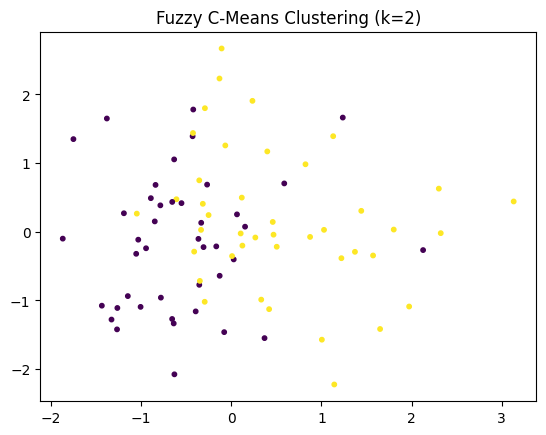

In [ ]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt

# Choose the number of clusters
n_clusters = 2  # Based on your findings with Agglomerative Clustering

# Apply Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X_Scaled.T, n_clusters, m=2, error=0.005, maxiter=1000, init=None)

# Find the highest membership value for each data point (assign cluster based on max membership)
labels = np.argmax(u, axis=0)

# Visualize the clustering result
plt.scatter(X_Scaled[:, 0], X_Scaled[:, 1], c=labels, cmap="viridis", s=10)
plt.title("Fuzzy C-Means Clustering (k=2)")
plt.show()


In [ ]:
#KMeans++ clustering only (Baseline).

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Make sure to import

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y_numeric, test_size=0.3)

# Train a KMeqns++ (baseline)
clf = KMeans(n_clusters=2, init="k-means++")
clf.fit(X_train, y_train)

y_pred_baseline = clf.predict(X_train)  # Store baseline predictions
accuracy_baseline = accuracy_score(y_train, y_pred_baseline)

# Use a different variable name to store the calculated silhouette score
current_silhouette_score = silhouette_score(X_train, y_pred_baseline)
print(f"Baseline Accuracy: {accuracy_baseline:.4f}")
print(f"Silhouette score is: {current_silhouette_score}")

Baseline Accuracy: 0.5172
Silhouette score is: 0.24206623585214462


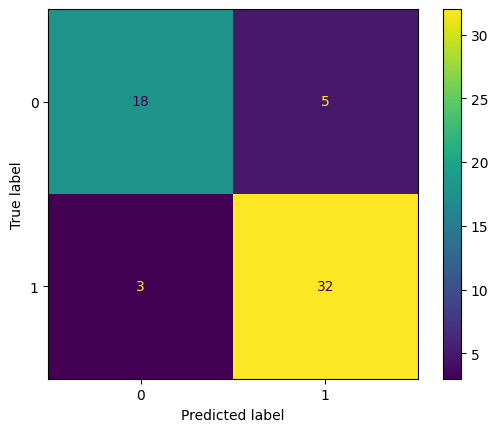

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_baseline)

display=ConfusionMatrixDisplay(cm)
display.plot()


In [ ]:
#SVC classification only (Baseline)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y_numeric, test_size=0.3)

# Train a SVC classifier (baseline)
clf = SVC(probability=True, kernel="linear")
clf.fit(X_train, y_train)

y_pred_baseline = clf.predict(X_train)
accuracy_baseline = accuracy_score(y_train, y_pred_baseline)

print(f"Baseline Accuracy (No Clustering): {accuracy_baseline:.4f}")

Baseline Accuracy (No Clustering): 0.8276


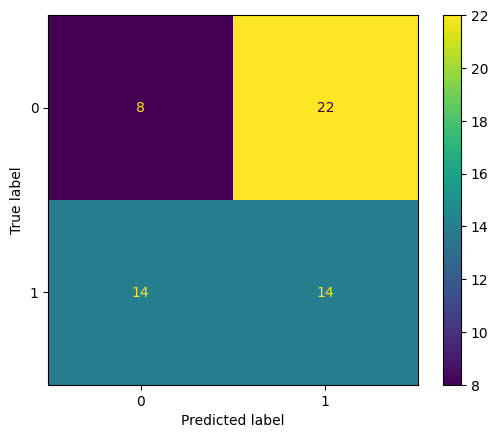

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_baseline)

display=ConfusionMatrixDisplay(cm)
display.plot()
